In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir('../input/flowers-recognition/flowers'))
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['tulip', 'daisy', 'sunflower', 'rose', 'flowers', 'dandelion']


In [2]:
import glob
from pathlib import Path
flower_dir = Path('../input/flowers-recognition/flowers/*/*')
flowers = {}
for directory in glob.glob(os.path.abspath(flower_dir)):
    dir_list = []
    dir_list = directory.split('/')
    images = []
    for files in glob.glob(directory + '/*.jpg'):
        images.append(files)
        flowers.setdefault(dir_list[-1], images)
    


In [3]:
label = []
Image = []
for keys, values in flowers.items():
    for v in values:
        Image.append(v)
        label.append(keys)

len(Image), len(label)

(4323, 4323)

# Data Visualization 

Let's see some of the random images and their respective labels.

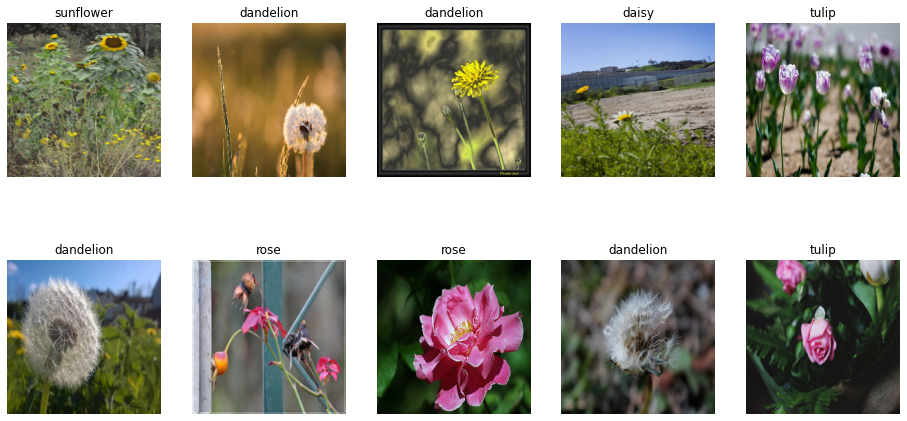

In [4]:
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt

Image, label = shuffle(Image, label, random_state = 0)

f, ax = plt.subplots(2,5, figsize = (16,8))
for i in range(10):
    img = Image[i]
    img = cv2.imread(img)
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title(label[i])
plt.show()

Creating a dataframe. Working with a dataframe is way easier for me, so creating a data frame from the list of image names and thier respective labels.

In [5]:
data_df = pd.DataFrame(list(zip(Image, label)),columns = ['Image', 'Label'])
data_df

,Image,Label
0,/kaggle/input/flowers-recognition/flowers/flow...,sunflower
1,/kaggle/input/flowers-recognition/flowers/flow...,dandelion
2,/kaggle/input/flowers-recognition/flowers/flow...,dandelion
3,/kaggle/input/flowers-recognition/flowers/flow...,daisy
4,/kaggle/input/flowers-recognition/flowers/flow...,tulip
...,...,...
4318,/kaggle/input/flowers-recognition/flowers/flow...,daisy
4319,/kaggle/input/flowers-recognition/flowers/flow...,rose
4320,/kaggle/input/flowers-recognition/flowers/flow...,daisy
4321,/kaggle/input/flowers-recognition/flowers/flow...,rose


**Chaning the labels (strings) into numbers.**
Since we have to pass the labels into an encoder later on so this is a very important step.

In [6]:
types_of_flowers = ['rose','dandelion', 'daisy', 'tulip', 'sunflower']
map = {}
for i in range(len(types_of_flowers)):
    map[types_of_flowers[i]] = i


for x in range(data_df.shape[0]):
    data_df['Label'][x] = map[data_df['Label'][x]]
data_df

,Image,Label
0,/kaggle/input/flowers-recognition/flowers/flow...,4
1,/kaggle/input/flowers-recognition/flowers/flow...,1
2,/kaggle/input/flowers-recognition/flowers/flow...,1
3,/kaggle/input/flowers-recognition/flowers/flow...,2
4,/kaggle/input/flowers-recognition/flowers/flow...,3
...,...,...
4318,/kaggle/input/flowers-recognition/flowers/flow...,2
4319,/kaggle/input/flowers-recognition/flowers/flow...,0
4320,/kaggle/input/flowers-recognition/flowers/flow...,2
4321,/kaggle/input/flowers-recognition/flowers/flow...,0


# **Data Generator**

Using a simple data generator which does the data preprocessing and label encodings.

In [7]:
from keras.utils import to_categorical

def data_generator(data, batch_size):
    num_samples = len(data)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset: offset+batch_size]
            X = []
            y = []
            for ind in batch_samples.index:
                img = batch_samples['Image'][ind]
                label = batch_samples['Label'][ind]
                
                encoded_label = to_categorical(label, num_classes=5)
                
                img = cv2.imread(str(img))
                img = cv2.resize(img, (224,224))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                if img.shape[2]==1:
                    img = np.dstack([img, img, img])
                img = img.astype(np.float32)/255    
                
                X.append(img)
                y.append(encoded_label)
            
            
            X = np.asarray(X).astype(np.float32)
            y = np.asarray(y)
            
            yield X, y
        
        
    

# Building the model.

This model consists of Convolutional layers and Seperable convolutional layers.

In [8]:
                                              
import tensorflow as tf
from keras.layers import Conv2D, Flatten, Dense, Dropout, Input, MaxPooling2D, GlobalMaxPooling2D, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop

def build_model():
    input_img = Input(shape = (224,224,3), name = 'ImageInput')
    x = Conv2D(64, (3,3), activation = 'relu', padding = 'same', name = 'Conv1_1' )(input_img)
    x = Conv2D(63, (3,3), activation = 'relu', padding = 'same', name = 'Conv1_2' )(x)
    x = MaxPooling2D((2,2), name = 'pool1')(x)
    
    x = tf.keras.layers.SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same', name = 'Conv2_2')(x)
    x = MaxPooling2D((2,2), name = 'pool2')(x)
    
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'Conv3_1')(x)
    x = BatchNormalization(name = 'bn1')(x)
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'Conv3_2')(x)
    x = BatchNormalization(name = 'bn2')(x)
    x = tf.keras.layers.SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same', name = 'Conv3_3')(x)
    x = MaxPooling2D((2,2), name = 'pool3')(x)
    
    x = tf.keras.layers.SeparableConv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'Conv4_1')(x)
    x = BatchNormalization(name = 'bn3')(x)
    x = tf.keras.layers.SeparableConv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'Conv4_2')(x)
    x = BatchNormalization(name = 'bn4')(x)
    x = tf.keras.layers.SeparableConv2D(512, (3,3), activation = 'relu', padding = 'same', name = 'Conv4_3')(x)
    x = MaxPooling2D((2,2), name = 'pool4')(x)
    
    x = Flatten(name = 'flatten')(x)
    x = Dense(1024,activation = 'relu', name = 'fc1')(x)
    x = Dropout(0.7, name = 'dropout1')(x)
    x = Dense(512, activation = 'relu', name = 'fc2')(x)
    x = Dropout(0.5, name = 'dropout2')(x)
    x = Dense(5, activation = 'softmax', name = 'fc3')(x)
    
    model = Model(inputs = input_img, outputs = x)
    return model

In [9]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 63)      36351     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 63)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8759      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

**Importing weigths from VGG16 pre-trained model**

In [10]:

from keras.applications.vgg16 import VGG16, preprocess_input
import h5py

f = h5py.File('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]
w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 63)      36351     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 63)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8759      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

**Compiling the model**

In [11]:
batch_size = 20
opt = Adam(lr=0.0001, decay=1e-5)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])


**Splitting the data into training data and validation data**

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(data_df, test_size = 0.25, random_state = 30)


print(X_train.shape)
print(X_val.shape)


(3242, 2)
(1081, 2)


**Calling the data generator function for defining trainng and validation data generator**

In [13]:
batch_size = 20
train_data_gen = data_generator(X_train, batch_size)
val_data_gen = data_generator(X_val, batch_size)

**Defining callbacks for the model.** With an simple earlyStopping and Reduce Learning Rate on Plateau class.

In [14]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlyStopping = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 10, verbose =1, factor = 0.5,
                                           min_lr = 0.0001)
callback = [earlyStopping, learning_rate_reduction]

ephs = 20
steps_per_ephs = X_train.shape[0]//batch_size
val_steps = X_val.shape[0]//batch_size

# Training the model!

Here I have trained the model till 20 epochs and further increment in the epochs might increase the accuracy.

In [15]:
history = model.fit_generator(train_data_gen, epochs = ephs, validation_data = val_data_gen,
                             validation_steps = val_steps, steps_per_epoch = steps_per_ephs,
                             callbacks = callback)

Epoch 1/20
162/162 [==============================] - 44s 272ms/step - loss: 1.6022 - accuracy: 0.2506 - val_loss: 1.6041 - val_accuracy: 0.2380 - lr: 1.0000e-04
Epoch 2/20
162/162 [==============================] - 40s 248ms/step - loss: 1.4512 - accuracy: 0.3706 - val_loss: 1.6086 - val_accuracy: 0.2380 - lr: 1.0000e-04
Epoch 3/20
162/162 [==============================] - 40s 245ms/step - loss: 1.3069 - accuracy: 0.4466 - val_loss: 1.6012 - val_accuracy: 0.2593 - lr: 1.0000e-04
Epoch 4/20
162/162 [==============================] - 41s 251ms/step - loss: 1.1905 - accuracy: 0.5062 - val_loss: 1.4040 - val_accuracy: 0.5444 - lr: 1.0000e-04
Epoch 5/20
162/162 [==============================] - 40s 249ms/step - loss: 1.0910 - accuracy: 0.5515 - val_loss: 1.2543 - val_accuracy: 0.4463 - lr: 1.0000e-04
Epoch 6/20
162/162 [==============================] - 40s 247ms/step - loss: 1.0155 - accuracy: 0.6061 - val_loss: 1.0102 - val_accuracy: 0.5981 - lr: 1.0000e-04
Epoch 7/20
162/162 [========

# Visualizing the model performance 

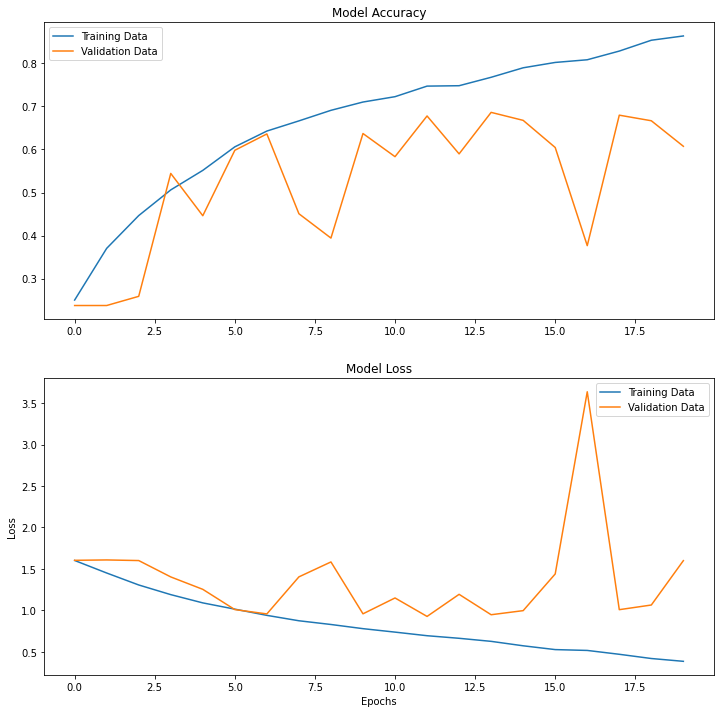

In [16]:
f, (ax1, ax2) = plt.subplots(2,1, figsize = (12,12))
ax1.plot(history.history['accuracy'], label = 'Training Accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax1.legend(['Training Data', 'Validation Data'], loc = 'best')

ax2.plot(history.history['loss'], label = 'Training loss')
ax2.plot(history.history['val_loss'], label = 'Validation Loss')
ax2.set_title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax2.legend(['Training Data', 'Validation Data'], loc = 'best')

**Please drop an upvote while you are here.** I am a newbie and solemnly welcome critics and comments from you, still have a long way to go.
Thank You!!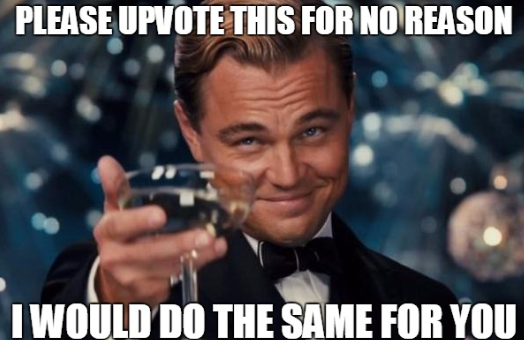